## Preprocessing of imaging data
### Load, parse metadata and generate data object

In [50]:
from ScanImageTiffReader import ScanImageTiffReader
import json
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as ppatch
import numpy as np

#from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

from skimage.registration import phase_cross_correlation
from scipy.ndimage import fourier_shift
from scipy.ndimage.filters import gaussian_filter

import napari

#for roi generation
import shapely as sp
from shapely.geometry.polygon import LinearRing, Polygon, LineString

In [51]:
#from roiVisualization import myAxisTheme

In [89]:
dataDir = '../sample'
rawTiff = 'SS96_x_7f_25per_allProjectorsOn_00002.tif'
plotDir = sep.join([dataDir, 'plot'])

print(dataDir)
print(plotDir)

../sample
../sample/plot


In [90]:
genotype = '-'.join(rawTiff.split('_')[0:3])
[flyID, date, condition] = rawTiff.split('_')[3:6] # dataDir.split(sep)[-4:-1]
#[age, condition] = rawTiff.split('_')[-3:-1]
age = 'na'
region = 'EB'
trial = rawTiff.split('_')[-1][:-4]
print(genotype, region, flyID, age, condition, trial, date)

SS96-x-7f EB 25per na 00002.tif 00002 allProjectorsOn


In [91]:
sep.join([plotDir,genotype,condition,flyID])

'../sample/plot/SS96-x-7f/00002.tif/25per'

In [92]:
# Generate directory where to save plots
saveDir = sep.join([plotDir,genotype,condition,flyID])
if not exists(saveDir):
    makedirs(saveDir)
print(saveDir)

../sample/plot/SS96-x-7f/00002.tif/25per


### Load tiff file

#### Extract relevant information from header

In [93]:
#with ScanImageTiffReader("data/resj_00001.tif") as reader:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))

In [94]:
metadat = mytiffreader.metadata()

In [95]:
# suggested by scanimage docs; does not work
#import json
#with ScanImageTiffReader(sep.join([dataDir, rawTiff])) as reader:
#    o=json.loads(reader.metadata())
#    print(o["RoiGroups"]["imagingRoiGroup"]["rois"]["scanfields"]["affine"])

In [96]:
# Print header except for dictionary
#for i, line in enumerate(metadat.split('\n')):
#    if 'SI' in line: print(line)

In [97]:
for i, line in enumerate(metadat.split('\n')):
    if not 'SI.' in line: continue
    # extract version
    if 'VERSION_' in line: print(line)

    # get channel info
    if 'channelSave' in line:
        print(line)
        if not '[' in line:
            nCh = 1
        else:
            nCh = int(line.split('=')[-1].strip())

    if 'scanFrameRate' in line:
        fpsscan = float(line.split('=')[-1].strip())

    #if 'hFastZ' in line:
    if 'discardFlybackFrames' in line:
        discardFBFrames = line.split('=')[-1].strip()

    if 'numDiscardFlybackFrames' in line:
        nDiscardFBFrames = int(line.split('=')[-1].strip())

    if 'numFramesPerVolume' in line:
        fpv = int(line.split('=')[-1].strip())

    if 'numVolumes' in line:
        nVols = int(line.split('=')[-1].strip())
            
print(' # channels: {}\n fly back? {}\n # discard frames: {}\n # frames/volume: {}\n # volumes: {}'.\
      format(nCh, discardFBFrames, nDiscardFBFrames, fpv, nVols))

SI.VERSION_COMMIT = '4a9264c4fccd21a03258704d0d6489537ad79e6c'
SI.VERSION_MAJOR = '2018b'
SI.VERSION_MINOR = '1'
SI.hChannels.channelSave = 1
 # channels: 1
 fly back? false
 # discard frames: 0
 # frames/volume: 10
 # volumes: 200


In [98]:
matches = [line for line in metadat.split('\n') if not 'SI.' in line]
m = '\n'.join(matches[1:-1])
#matches[1:-1]
metadict = json.loads(m)

roiGroups = metadict['RoiGroups']
print(roiGroups.keys())
print(json.dumps(roiGroups['imagingRoiGroup']['rois']['UserData'],indent=4))

dict_keys(['imagingRoiGroup', 'photostimRoiGroups', 'integrationRoiGroup'])
{
    "imagingSystem": "ResScanner",
    "fillFractionSpatial": 0.9,
    "forceSquarePixelation": 1,
    "forceSquarePixels": 1,
    "scanZoomFactor": 5,
    "scanAngleShiftFast": 0,
    "scanAngleMultiplierSlow": 1,
    "scanAngleShiftSlow": 0,
    "scanRotation": 0,
    "pixelsPerLine": 512,
    "linesPerFrame": 512
}


In [99]:
vps =  fpsscan/fpv #volumes per second = fpv / fpsscan
print('frame rate per volume [Hz]: {}'.format(vps))

frame rate per volume [Hz]: 3.00275


#### Read and reshape image tiff stack

In [100]:
caCh = 0

In [101]:
vol = mytiffreader.data()
volshape = vol.shape
print(volshape)

(2000, 512, 512)


In [102]:
vol = vol.reshape((int(volshape[0]/(fpv*nCh)),fpv,nCh,volshape[1], volshape[2]))
print('Full dimensional stack: rawstack')
print(vol.shape)

stack4d = np.squeeze(vol[:,0:fpv-nDiscardFBFrames,caCh,:,:])
print('Stack reduced to one color channel and flyback frames discrded: stack4d')
print(stack4d.shape)

Full dimensional stack: rawstack
(200, 10, 1, 512, 512)
Stack reduced to one color channel and flyback frames discrded: stack4d
(200, 10, 512, 512)


#### Max projections
...along z-volumes

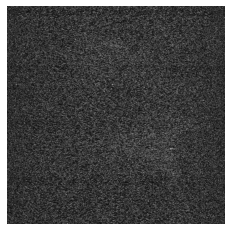

In [103]:
stackMP = stack4d.max(axis=1)
stackMP.shape
fig,ax = plt.subplots(1,1)
ax.imshow(stackMP[1],cmap='Greys_r',origin='lower')
ax.axis('off');

...along z and t

In [104]:
stackMPall = stackMP.max(axis=0)
print(stackMPall.shape)

(512, 512)


### Motion correction
#### Correct translation in x/y using phase correlation
Note: Currently only works on max projection, not on sequence of z-stacks

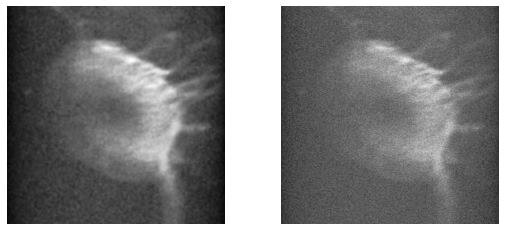

In [106]:
# Settings
## reference image
numRefImg = 600
locRefImg = round(nVols/3)

## registration
upsampleFactor = 20

# Generate reference image
refImg = np.mean(stackMP[locRefImg:locRefImg+numRefImg,:,:],axis=0)

refImgFilt = gaussian_filter(refImg, sigma=2)

fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(refImgFilt,cmap='Greys_r', origin='lower')
ax[0].axis('off');
ax[1].imshow(refImg,cmap='Greys_r', origin='lower')
ax[1].axis('off');

In [107]:
shift = np.zeros((2, nVols))
error = np.zeros(nVols)
diffphase = np.zeros(nVols)

stackMPMC = np.ones(stackMP.shape).astype('int16')

for i in range(nVols):
    shifImg = stackMP[i,:,:]
    
    shifImgFilt = gaussian_filter(shifImg, sigma=2)
    
    # subpixel precision
    shift[:,i], error[i], diffphase[i] = phase_cross_correlation(refImgFilt, shifImgFilt, 
                                                                 upsample_factor = upsampleFactor)
    
    offset_image = fourier_shift(np.fft.fftn(shifImg), shift[:,i])
    stackMPMC[i,:,:] = np.fft.ifftn(offset_image).real.astype('uint16')

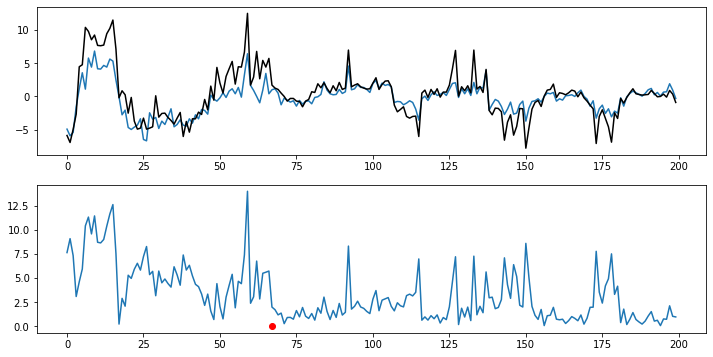

In [108]:
fig, axs = plt.subplots(2,1,figsize=(12,6))
axs[0].plot(shift[0,:])
axs[0].plot(shift[1,:],'k')

axs[1].plot(np.hypot(shift[0,:],shift[1,:]))
axs[1].plot(locRefImg,0,'ro')

### Draw ROI and extract time series from wedges
#### Open registered image stack or reference image in napari and draw roi guides

In [109]:
%gui qt5

viewer = napari.view_image(refImgFilt)

#### Draw guide lines for EB roi segmentation
* draw an outline of the EB (free hand form) -> name "EBoutline"
* draw two lines marking the axes of the ellipse (line forms) -> name "EBlongaxis" and "EBshortaxis"

In [72]:
# you can also draw a mask:
#ebfill = viewer.layers["EBfill"]
#fig, ax = plt.subplots(1,1,figsize=(5,5))
#ax.imshow(refImg,cmap='Greys_r', vmin=0, origin='upper')
#ax.axis('off');
#ax.imshow(ebfill.data, cmap='Reds', alpha=0.2)
#ebfill.data

In [110]:
ebouter = viewer.layers["EBoutline"].data[0]
eblongax = viewer.layers["EBlongaxis"].data[0]
ebshortax = viewer.layers["EBshortaxis"].data[0]
print(ebshortax)

[[341.93412375 357.88548509]
 [195.77513839 120.46987436]]


#### Generate shapely-objects to represent ROIs

In [111]:
EBroiRing = LinearRing(ebouter)
EBroiPoly = Polygon(ebouter)
EBaxisL = LineString(eblongax)
EBaxisS = LineString(ebshortax)

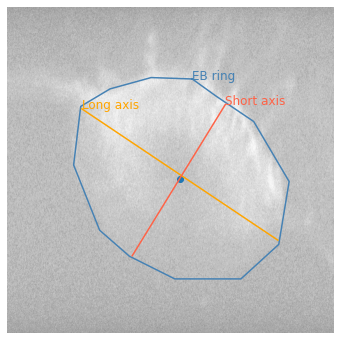

In [112]:
fig, axs = plt.subplots(1,1, figsize=(6,6))

axs.imshow(np.mean(stackMPMC,axis=0).T,cmap='Greys_r', vmin=0, origin='lower')

axs.plot(EBroiRing.coords.xy[0],EBroiRing.coords.xy[1], color='steelblue')
axs.text(EBroiRing.coords[0][0], EBroiRing.coords[0][1], 'EB ring', color='steelblue', fontsize=12)
axs.plot(EBroiRing.centroid.coords.xy[0],EBroiRing.centroid.coords.xy[1],'o')
axs.plot(EBaxisL.coords.xy[0], EBaxisL.coords.xy[1], color='orange')
axs.text(EBaxisL.coords[0][0], EBaxisL.coords[0][1], 'Long axis', color='orange', fontsize=12)
axs.plot(EBaxisS.coords.xy[0], EBaxisS.coords.xy[1], color='tomato')
axs.text(EBaxisS.coords[0][0], EBaxisS.coords[0][1], 'Short axis', color='tomato', fontsize=12)
axs.set_aspect('equal')
axs.axis('off');

In [113]:
ellipseCntr = EBroiRing.centroid.coords[0]
print('EB center coordinates (px): {0}'.format(ellipseCntr))

print('EB axis lengths:  axis 1 = {0}, axis 2 = {1}'.format(round(EBaxisL.length/2.), round(EBaxisS.length/2.)))

axvec = abs(np.asarray(EBaxisL.coords[0])-np.asarray(EBaxisL.coords[1]))
ellipseRot = 90-np.arctan(axvec[0]/axvec[1])*180/np.pi
print('EB main axis rotation (deg): {0}'.format(round(ellipseRot)))

EB center coordinates (px): (271.1316951355634, 240.94755484082148)
EB axis lengths:  axis 1 = 185, axis 2 = 139
EB main axis rotation (deg): 34


In [114]:
# 1st elem = center point (x,y) coordinates
# 2nd elem = the two semi-axis values (along x, along y)
# 3rd elem = angle in degrees between x-axis of the Cartesian base
#            and the corresponding semi-axis
ellipse = (ellipseCntr,(EBaxisL.length/2., EBaxisS.length/2.),ellipseRot)

# Let create a circle of radius 1 around center point:
circ = sp.geometry.Point(ellipse[0]).buffer(1)

# Let create the ellipse along x and y:
ell  = sp.affinity.scale(circ, int(ellipse[1][0]), int(ellipse[1][1]))

# Let rotate the ellipse (counterclockwise, x axis pointing right):
ell = sp.affinity.rotate(ell,-ellipse[2])
# According to the man, a positive value means a anti-clockwise angle,
# and a negative one a clockwise angle.

EBoutline = ell.exterior

In [132]:
# Find points on EB outline
nsteps = 16#8
EBroiPts = [ellipseCntr]

for s in range(nsteps):
    [sx,sy] = EBoutline.interpolate(s/nsteps, normalized=True).coords.xy
    EBroiPts.append((sx[0],sy[0]))
    
# Shift ROI pts circularely to start at ventral part of EB
st = 3#1
EBroiPtsCopy = EBroiPts.copy()

for s in range(1,nsteps+1):
    EBroiPts[s] = EBroiPtsCopy[(s+st)%nsteps+1]

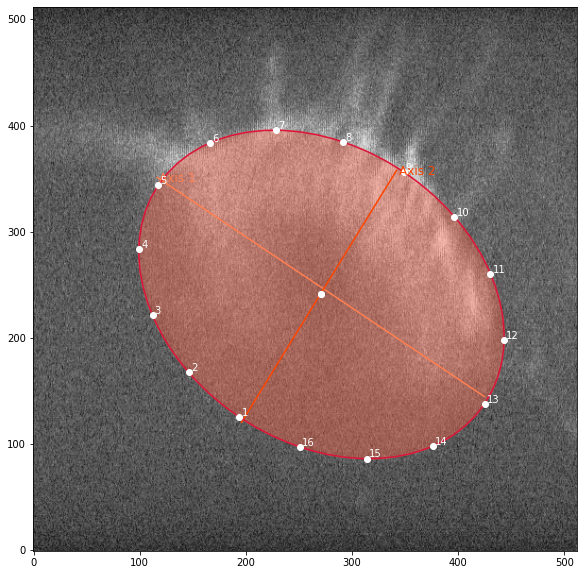

In [133]:
fig, axs = plt.subplots(1,1, figsize=(10,10))

#axs.imshow(np.mean(stackMPMC,axis=0).T,cmap='Greys_r', origin='upper')
axs.imshow(refImg.T,cmap='Greys_r',origin='lower')

patch = ppatch.Ellipse(ellipseCntr, EBaxisL.length, EBaxisS.length, -ellipseRot, alpha = 0.4, color='tomato')
axs.add_patch(patch)
axs.plot(EBaxisL.coords.xy[0], EBaxisL.coords.xy[1], color='coral')
axs.text(EBaxisL.coords[0][0]+2, EBaxisL.coords[0][1]-4, 'Axis 1', color='coral', fontsize=12)
axs.plot(EBaxisS.coords.xy[0], EBaxisS.coords.xy[1], color='orangered')
axs.text(EBaxisS.coords[0][0]+2, EBaxisS.coords[0][1]-4, 'Axis 2', color='orangered', fontsize=12)

axs.plot(EBoutline.coords.xy[0],EBoutline.coords.xy[1], color='crimson')
axs.plot(EBroiPts[0][0],EBroiPts[0][1], 'wo')

for s in range(nsteps):
    axs.plot(EBroiPts[s+1][0],EBroiPts[s+1][1], 'wo')
    axs.text(EBroiPts[s+1][0]+2,EBroiPts[s+1][1]+1, str(s+1), color='w')
axs.plot(ellipseCntr[0],ellipseCntr[1],'wo')

In [134]:
EBroiPolys = []
for s in range(nsteps):
    if s+1==nsteps:
        EBroiPolys.append([EBroiPts[0],EBroiPts[s+1],EBroiPts[1]])
    else:
        EBroiPolys.append([EBroiPts[0],EBroiPts[s+1],EBroiPts[s+2]])

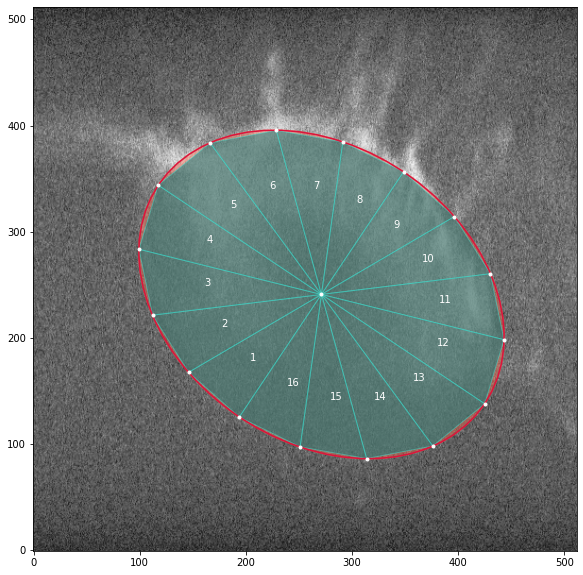

In [135]:
fig, axs = plt.subplots(1,1, figsize=(10,10))
axs.imshow(np.mean(stackMPMC,axis=0).T,cmap='Greys_r', origin='lower')

#patch = PolygonPatch(ell, alpha = 0.3, color='tomato')
EBpatch = ppatch.Ellipse(ellipseCntr, EBaxisL.length, EBaxisS.length, -ellipseRot, alpha = 0.4, color='tomato')

axs.add_patch(EBpatch)
axs.plot(EBoutline.coords.xy[0],EBoutline.coords.xy[1], color='crimson')

for s in range(nsteps):
    roiPatch = ppatch.Polygon(EBroiPolys[s],alpha=0.5, edgecolor='turquoise', facecolor='teal')
    axs.add_patch(roiPatch)
    labcoord = Polygon(EBroiPolys[s]).centroid.coords.xy
    axs.text(labcoord[0][0],labcoord[1][0], str(s+1), color='w')
    axs.plot(EBroiPts[s+1][0],EBroiPts[s+1][1], 'w.')
axs.plot(EBroiPts[0][0],EBroiPts[0][1], 'w.')

In [136]:
# create a list of possible pixel coordinates
imgrid = np.meshgrid(np.arange(0,stackMPMC.shape[1]), np.arange(0,stackMPMC.shape[2]))
pxcoords = list(zip(*(c.flat for c in imgrid)))


# Get all points in EB ellipse
EBPatch = ppatch.Polygon(EBroiPts[1:])
roiPts_x = [p[0] for p in pxcoords if EBPatch.contains_point(p, radius=0)]
roiPts_y = [p[1] for p in pxcoords if EBPatch.contains_point(p, radius=0)]

EBCoords = np.vstack((roiPts_x,roiPts_y))

# List for all roi point lists
EBroiCoords = []

for s in range(nsteps):
    roiPatch = ppatch.Polygon(EBroiPolys[s])

    # create the list of valid coordinates (from untransformed)
    roiPts_x = [p[0] for p in pxcoords if roiPatch.contains_point(p, radius=0)]
    roiPts_y = [p[1] for p in pxcoords if roiPatch.contains_point(p, radius=0)]
    EBroiCoords.append(np.vstack((np.asarray(roiPts_x),np.asarray(roiPts_y))))
    
len(EBroiCoords)

16

In [137]:
# Gaussian-filter each frame before computing DF/F
#gaussianSize = (2, 2)
gaussianSigma = 2

stackMPGFilt = np.zeros((stackMP.shape))

for i in range(nVols):
    stackMPGFilt[i,:,:] = gaussian_filter(stackMPMC[i,:,:], gaussianSigma, mode='reflect')
    

In [124]:
viewer2 = napari.view_image(stackMPGFilt)

In [138]:
# Currently F_0 is estimated for the whole time series 
# (ok, if time series is short but should really be computed in moving window)
baseLinePercent = 10
offset = 0.0001

EBtraces = np.zeros((nsteps,stackMPGFilt.shape[0]))
for s in range(nsteps):
    Fraw = stackMPGFilt[:,EBroiCoords[s][0],EBroiCoords[s][1]].mean(1)
    
    # Estimate baseline
    F0 = np.percentile(Fraw, baseLinePercent)
    if F0 == 0: F0 += offset
    
    # Compute dF/F_0 = (F_raw - F_0)/F_0
    dFF = (Fraw - F0) / F0
    
    EBtraces[s,:] = dFF
    
EBFraw = stackMPGFilt[:,EBCoords[0,:],EBCoords[1,:]].mean(1)
    
# Estimate baseline
EBF0 = np.percentile(EBFraw, baseLinePercent)
if EBF0 == 0: EBF0 += offset
    
# Compute dF/F_0 = (F_raw - F_0)/F_0
EBdFF = (EBFraw - EBF0) / EBF0
    
time = np.linspace(0, nVols/vps, nVols)

In [139]:
# filter DF/F trace with Savitzky-Golay filter
# 3rd order, 7 frames
from scipy.signal import savgol_filter

order = 3
window = 7

EBtracesFilt = np.zeros((nsteps,stackMPMC.shape[0]))

for s in range(nsteps):
    filtDFF = savgol_filter(EBtraces[s,:], window, order)
    EBtracesFilt[s,:] = filtDFF
    

<ipython-input-140-c3c8b7d8608d>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = axs[1].pcolor(time,np.arange(0,nsteps+1),EBtracesFilt,cmap='Blues', edgecolors='face')


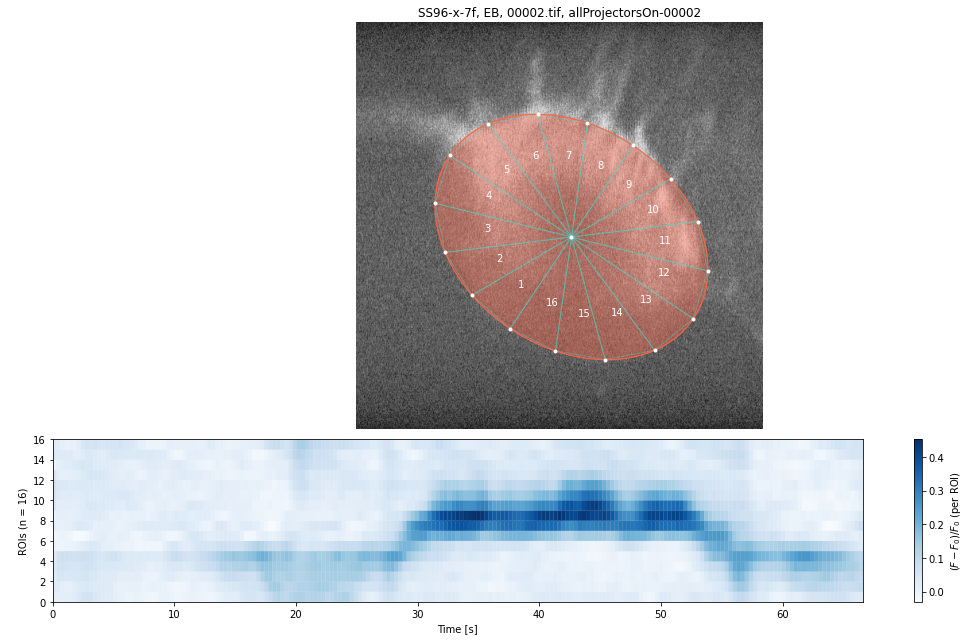

In [140]:
fig, axs = plt.subplots(2,1, figsize=(15,9),gridspec_kw={'height_ratios':[2.5,1]})

axs[0].imshow(np.mean(stackMP,axis=0).T,cmap='Greys_r', origin='lower')#, vmin=0, vmax=0.7*np.max(stackMP))

#patch = PolygonPatch(ell, alpha = 0.3, color='tomato')
patch = ppatch.Ellipse(ellipseCntr, EBaxisL.length, EBaxisS.length, -ellipseRot, alpha = 0.4, color='tomato')

axs[0].add_patch(patch)
axs[0].plot(EBoutline.coords.xy[0],EBoutline.coords.xy[1], color='tomato', linewidth=1)

for s in range(nsteps):
    roiPatch = ppatch.Polygon(EBroiPolys[s],alpha=0.4, edgecolor='turquoise', facecolor='none')
    axs[0].add_patch(roiPatch)
    axs[0].plot(EBroiPts[s+1][0],EBroiPts[s+1][1], 'w.')
    labcoord = Polygon(EBroiPolys[s]).centroid.coords.xy
    axs[0].text(labcoord[0][0],labcoord[1][0], str(s+1), color='w')

axs[0].plot(EBroiPts[0][0],EBroiPts[0][1], 'w.')
axs[0].axis('off')
axs[0].set_title(', '.join([genotype, region, condition, date+'-'+trial]))

#cax = axs[1].imshow(EBtraces,cmap='Blues', aspect=20, interpolation='None', origin='lower', vmin=0)
cax = axs[1].pcolor(time,np.arange(0,nsteps+1),EBtracesFilt,cmap='Blues', edgecolors='face')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('\nROIs (n = {0})'.format(nsteps))
#myAxisTheme(axs[1])

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax)
cbar.set_label('$(F - F_0) / F_0$ (per ROI)')  # vertically oriented colorbar

fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['roiMap-dFFtimeseries',genotype, region, flyID, age, condition, trial])+'.pdf')

#### Save ROI time series

#### Compute PVA

In [433]:
def computePVA (locs, weights):
    """ Compute population vector average
    """
    nsteps = weights.shape[0]
    nvol = weights.shape[1]
    pva_x = np.cos(np.reshape(np.tile(locs,nvol),[nvol,nsteps])).T*weights
    pva_y = np.sin(np.reshape(np.tile(locs,nvol),[nvol,nsteps])).T*weights
    
    pva = np.vstack((sum(pva_x)/len(pva_x), sum(pva_y)/len(pva_x)))
    return pva

In [437]:
roiArcPos = np.linspace(0, 2*np.pi, nsteps+1)[:-1]

pva = computePVA(roiArcPos,EBtracesFilt)
pvaRad = np.arctan2(pva[1,:],pva[0,:])
pvaLen = np.hypot(pva[0,:],pva[1,:])

PVAst = 3#7.5
pvaRoi = np.mod((np.unwrap(pvaRad,np.pi) - pvaRad[0]) * nsteps/(2*np.pi) + PVAst, nsteps)

In [438]:
#plt.plot(time, computePVA(roiArcPos,EBtraces)[0],'k')
#plt.plot(time, computePVA(roiArcPos,EBtracesFilt)[0],'c')

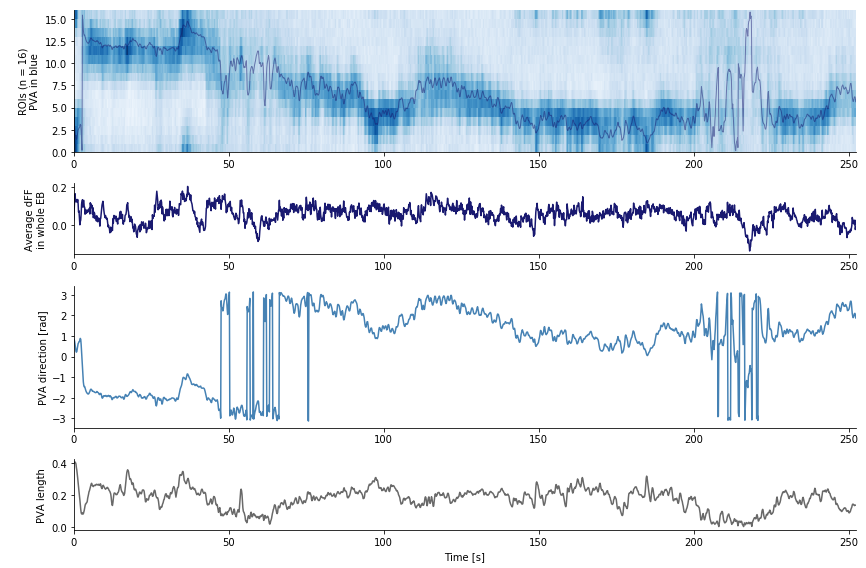

In [439]:
fig, axs = plt.subplots(4,1, figsize=(12,8),gridspec_kw={'height_ratios':[1,0.5, 1, 0.5]})
cax = axs[0].pcolor(time,np.arange(0,nsteps+1),EBtracesFilt,cmap='Blues', edgecolors='face')
axs[0].set_ylabel('\nROIs (n = {0})\nPVA in blue'.format(nsteps))
axs[0].plot(time,pvaRoi,'-', color='midnightblue', linewidth=1, alpha=0.5)


axs[1].plot(time,EBdFF,color='midnightblue')
axs[1].set_ylabel('Average dFF\nin whole EB')

axs[2].plot(time,pvaRad,color='steelblue')
axs[2].set_ylabel('PVA direction [rad]')
axs[3].plot(time,pvaLen,color='dimgrey')
axs[3].set_ylabel('PVA length')
axs[3].set_xlabel('Time [s]')

for ax in axs:
    myAxisTheme(ax)
    ax.set_xlim(time[0],time[-1])
    
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['dFFandPVA',genotype, region, flyID, age, condition, trial, date])+'.pdf')

## Load in position data

In [440]:
posDataMat = rawTiff[:-3]+'mat'
print(posDataMat)

GCaMP7f_x_SS96_f02_7-8d_clutterWGroundAndCyli_00004.mat


In [441]:
matstruct = sio.loadmat(dataDir+sep+posDataMat)
posDat = matstruct['positionDat']

In [442]:
print('For each loged time point, the following parameters are reported:')
print(posDat[0,][0].dtype)

For each loged time point, the following parameters are reported:
[('t', 'O'), ('OffsetRot', 'O'), ('OffsetFor', 'O'), ('OffsetLat', 'O'), ('dx0', 'O'), ('dx1', 'O'), ('dy0', 'O'), ('dy1', 'O'), ('closed', 'O'), ('direction', 'O'), ('trans', 'O'), ('olgain', 'O'), ('clgain', 'O'), ('exType', 'O'), ('tFrameGrab', 'O'), ('tVR', 'O')]


In [443]:
tmtime = np.ndarray.flatten(posDat[0,0][0])
print(len(tmtime))

osRot = np.ndarray.flatten(posDat[0,0][1])
osFwd = np.ndarray.flatten(posDat[0,0][2])
osLat = np.ndarray.flatten(posDat[0,0][3])

dx0 = np.ndarray.flatten(posDat[0,0][4])
dx1 = np.ndarray.flatten(posDat[0,0][5])
dy0 = np.ndarray.flatten(posDat[0,0][6])
dy1 = np.ndarray.flatten(posDat[0,0][7])

tFrameGrab = np.ndarray.flatten(posDat[0,0][14][0])
print(len(tFrameGrab))
tVR = np.ndarray.flatten(posDat[0,0][15][0])
print(len(tVR))

29513
21248
61896


In [444]:
minFG = np.floor(np.where(tFrameGrab >= tVR[0])[0][0]/fpv)
maxFG = np.round(len(tFrameGrab)/fpv)
FG = (int(minFG), int(maxFG))

In [445]:
def interpFrames(rawDat, FG, fpv, time, framegrab, tVR):

    interpDat = np.zeros((FG[1]-FG[0], 1))
    
    for i in range(FG[0],FG[1]):
        
        iMatch = np.where( time >= ( time[0] + (framegrab[(i-1)*fpv+1] - tVR[0])/10000 ) )[0][0]
        interpDat[i - FG[0]] = rawDat[iMatch]
    
    return interpDat

In [446]:
timeMatched = tFrameGrab[0::fpv]/10000
timeMatched = timeMatched[FG[0]:FG[1]]
print(len(timeMatched))

tmtimeMatch = np.ndarray.flatten(interpFrames(tmtime,FG, fpv, tmtime, tFrameGrab, tVR)) 
osRotMatch = np.ndarray.flatten(interpFrames(osRot,FG, fpv, tmtime, tFrameGrab, tVR))
osFwdMatch = np.ndarray.flatten(interpFrames(osFwd,FG, fpv, tmtime, tFrameGrab, tVR))
osLatMatch = np.ndarray.flatten(interpFrames(osLat,FG, fpv, tmtime, tFrameGrab, tVR))

dx0Match = np.ndarray.flatten(interpFrames(dx0,FG, fpv, tmtime, tFrameGrab, tVR))
dx1Match = np.ndarray.flatten(interpFrames(dx1,FG, fpv, tmtime, tFrameGrab, tVR))
dy0Match = np.ndarray.flatten(interpFrames(dy0,FG, fpv, tmtime, tFrameGrab, tVR))
dy1Match = np.ndarray.flatten(interpFrames(dy1,FG, fpv, tmtime, tFrameGrab, tVR))

1755


In [447]:
vFwdMatched = np.hstack((0,abs(np.diff(osFwdMatch))/np.diff(timeMatched)))
#vFwdMatched[vFwdMatched>2] = np.nan

vTransMatched = np.hypot(osFwdMatch, osLatMatch)
vTransMatched = np.hstack((0,abs(np.diff(vTransMatched))/np.diff(timeMatched)))

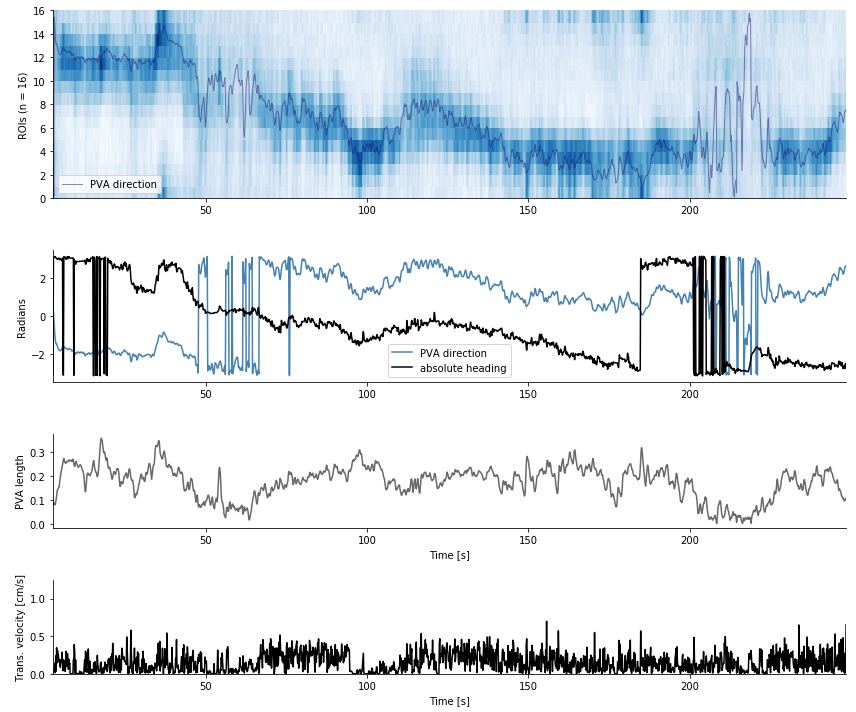

In [448]:
EBtracesMatched = EBtracesFilt[:,FG[0]:FG[1]]
pvaRoiMatched = pvaRoi[FG[0]:FG[1]]
pvaRadMatched = pvaRad[FG[0]:FG[1]]
pvaLenMatched = pvaLen[FG[0]:FG[1]]

from roiVisualization import myAxisTheme

fig, axs = plt.subplots(4,1, figsize=(12,10),gridspec_kw={'height_ratios':[1,0.7, 0.5, 0.5]})
cax = axs[0].pcolor(timeMatched,np.arange(0,nsteps+1),EBtracesMatched,cmap='Blues', edgecolors='face')
axs[0].set_ylabel('\nROIs (n = {0})'.format(nsteps))
axs[0].plot(timeMatched,pvaRoiMatched,'-', color='midnightblue', linewidth=1, alpha=0.5, label='PVA direction')
axs[0].legend()

axs[1].plot(timeMatched,pvaRadMatched,color='steelblue', label='PVA direction')
axs[1].plot(timeMatched,osRotMatch*np.pi/180.,color='black', label='absolute heading')
axs[1].set_ylabel('Radians')
axs[1].legend()

axs[2].plot(timeMatched,pvaLenMatched,color='dimgrey', label='PVA length')
axs[2].set_ylabel('PVA length')
axs[2].set_xlabel('Time [s]')

axs[3].plot(timeMatched,vTransMatched,color='black', label='transl. velocity')
axs[3].set_ylim(0,1.25)
axs[3].set_ylabel('Trans. velocity [cm/s]')
axs[3].set_xlabel('Time [s]')

for ax in axs:
    myAxisTheme(ax)
    ax.set_xlim(timeMatched[0],timeMatched[-1])
    
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['DFF-PVA-heading-fwdvelo', genotype, region, flyID, age, condition, trial, date])+'.pdf')

#### Relate PVA to relative heading (w.r.t. local landmark)

In [449]:
LMcoords = (0,0)

In [450]:
def dotproduct2d(a, b):
    # 2D dot product
    return a[0, :]*b[0, :] + a[1, :]*b[1, :]


def veclength2d(vec):
    return np.sqrt(vec[0, :]**2 + vec[1, :]**2)


def relationToObject(time, xPos, yPos, angle, objLocation):
    # Assumes only one object, thus in case of fly VR one needs to use the projected xPosMA

    # Vector to object location
    objDirection = np.vstack((objLocation[0]-xPos, objLocation[1]-yPos))

    objDistance = np.hypot(objLocation[0]-xPos, objLocation[1]-yPos)

    # Fly orientation vector
    flyDirection = np.vstack((np.cos(angle), np.sin(angle)))

    # Angle to object relative from fly's orientation
    lenFlyVec = np.hypot(flyDirection[0, :], flyDirection[1, :])
    lenObjVec = np.hypot(objDirection[0, :], objDirection[1, :])

    gamma = np.arccos(dotproduct2d(flyDirection, objDirection) / (lenFlyVec * lenObjVec))

    gammaFull = np.arctan2(flyDirection[1, :], flyDirection[0, :])-np.arctan2(objDirection[1, :], objDirection[0, :])
    gammaFull[gammaFull < 0] += 2 * np.pi
    gammaFull[gammaFull > np.pi] -= 2 * np.pi

    gammaV = np.hstack((np.diff(gamma)/np.diff(time), 0))

    return objDirection, objDistance, gammaFull, gamma, gammaV

In [451]:
_, LMdist, gamma, gammahalf, _ = relationToObject(tmtimeMatch, osFwdMatch, osLatMatch, osRotMatch*np.pi/180., LMcoords)

/Users/haberkernh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


In [460]:
# Change offset of PVA to match either abs. or rel. heading trace
PVAst = 0.2#-0.8
pvaPlot = np.mod((np.unwrap(pvaRadMatched,np.pi) + PVAst), np.pi*2) - np.pi

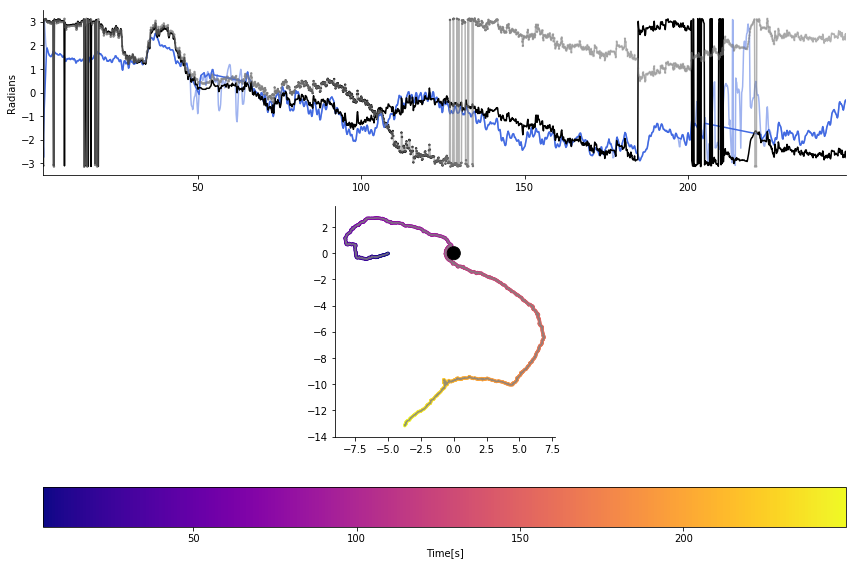

In [461]:
localLM = True
pvaLenTH = 0.1

fig, axs = plt.subplots(2,1, figsize=(12,8),gridspec_kw={'height_ratios':[1,2]})
axs[0].plot(timeMatched,pvaPlot,color='royalblue', alpha=0.5)
axs[0].plot(timeMatched[pvaLenMatched>pvaLenTH],pvaPlot[pvaLenMatched>pvaLenTH],color='royalblue', alpha=1, label='PVA direction')
#axs[0].plot(timeMatched,pvaRadMatched,color='royalblue', alpha=1, label='PVA direction')
#axs[0].scatter(timeMatched,pvaRadMatched, s=5, c=tmtimeMatch, cmap='plasma')
axs[0].plot(timeMatched,osRotMatch*np.pi/180.,color='black', label='absolute heading')
if localLM:
    axs[0].plot(timeMatched,gamma,color='grey',alpha=0.6, label='relative (LM) heading')
    axs[0].scatter(timeMatched,gamma,s=2, c=LMdist, cmap='Greys_r')
axs[0].set_ylabel('Radians')
#axs[0].legend()
axs[0].set_xlim(timeMatched[0],timeMatched[-1])

#cb = axs[1].scatter(osFwdMatch, osLatMatch, s=5, c=osRotMatch*np.pi/180, cmap='hsv')
axs[1].plot(osFwdMatch, osLatMatch,color='grey', alpha=0.8)
cb = axs[1].scatter(osFwdMatch, osLatMatch, s=5, c=tmtimeMatch, cmap='plasma')
plt.colorbar(cb, ax=axs[1], orientation='horizontal', label='Time[s]')
axs[1].set_aspect('equal')

if localLM:
    # add landmark
    from matplotlib.patches import Circle
    circle = Circle((0, 0), 0.5, color='black')
    axs[1].add_artist(circle)
    #axs[1].set_xlim(-10,5)

for ax in axs:
    myAxisTheme(ax)
    
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['PVA-absHead-relHead-traj',genotype, region, flyID, age, condition, trial, date])+'.pdf')

### Compute path directly from treadmill values

In [ ]:
conversionFactor_pitch = tmParams['px2mm']*float(tmParams['calibParam'][0])
conversionFactor_yaw = tmParams['px2mm']*float(tmParams['calibParam'][1])

gammaRad = 45*np.pi/180.0

time = np.linspace(0, trialS, len(tm_ticks['x1']))

# compute virtual rotation of fly
vFwd = - (tm_ticks['y1'] + tm_ticks['y2']) * np.cos(gammaRad); #add components along longitudinal axis
vSide = - (tm_ticks['y1'] - tm_ticks['y2']) * np.sin(gammaRad); #add components along transversal axis
vRot = - (tm_ticks['x1'] + tm_ticks['x2'])/2 #average measured displacement along aximuth

# convert A.U. --> pixel --> mm
vFwd = vFwd * conversionFactor_pitch # use scaling factor for pitch
vSide = vSide * 0.5*(conversionFactor_yaw + conversionFactor_pitch) #use mean
vRot = vRot * conversionFactor_yaw # use scaling factor for yaw

In [ ]:
# Compute path
# Assume initial position (0 0 0) = (x-coord, y-coord, theta): 
# --> fly in origin, aligned with x axis (head forward)
# During measurement coordinate system is fly-centered, moves with fly.
# Compute all changes along those axes by updating theta and
# projecting the position changes onto the fixed coordinate system

dt = np.hstack((np.diff(time),np.mean(np.diff(time)) ))

theta = np.cumsum(vRot * dt)
theta = np.mod((theta + np.pi),2*np.pi) - np.pi

# movement in x and y direction
yTM_i = vSide * np.cos(-theta) - vFwd * np.sin(-theta) #compute increments x_i
yTM = np.cumsum(yTM_i* dt) # integrate x_i to get path

xTM_i = vSide * np.sin(-theta) + vFwd * np.cos(-theta)
xTM = np.cumsum(xTM_i * dt)

transV = np.hypot(xTM_i, yTM_i)

In [ ]:
# downsample through linear interpolation

fps_ds = 500

time_ds = np.linspace(time[0], time[-1], int(fps_ds*time[-1]))

vFwd_ds = myInterpol(time_ds, time[:], vFwd)
vSide_ds = myInterpol(time_ds, time[:], vSide)
vRot_ds = myInterpol(time_ds, time[:], vRot)
arena_ds = myInterpol(time_ds, time[:], arena)

In [ ]:
# convert to cm/s
dt = np.hstack((np.diff(time_ds),np.mean(np.diff(time_ds)) ))
vFwd_ds = vFwd_ds / dt
vSide_ds = vSide_ds / dt
vRot_ds =  vRot_ds / dt

rotV_ds = vRot_ds / tmParams['rBall'] #cm/s to deg/s

theta_ds = np.cumsum(rotV_ds * dt)
theta_ds = np.mod((theta_ds + np.pi),2*np.pi) - np.pi

# movement in x and y direction
yTM_i = vSide_ds * np.cos(-theta_ds) - vFwd_ds * np.sin(-theta_ds) #compute increments x_i
yTM_ds = np.cumsum(yTM_i* dt) # integrate x_i to get path

xTM_i = vSide_ds * np.sin(-theta_ds) + vFwd_ds * np.cos(-theta_ds)
xTM_ds = np.cumsum(xTM_i * dt)

transV_ds = np.hypot(xTM_i, yTM_i)